In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [10]:
#生成数据y=X*w+b+c(噪声)
def synthetic_data(w,b,num_examples):
    X=torch.normal(0,1,(num_examples,len(w)))
    y=torch.matmul(X,w)+b
    y+=torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000)
labels[0] 

tensor([-3.5856])

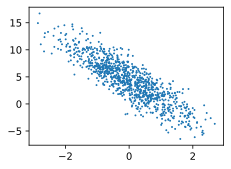

In [11]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)

In [29]:
#小批量随机取样
def data_iter(batch_size,features,labels):
    num_example=len(features)
    indices=list(range(num_example))
    random.shuffle(indices)
    for i in range(0,num_example,batch_size):
        batch_indices=torch.tensor(indices[i:min(i+batch_size,num_example)])
        yield features[batch_indices],labels[batch_indices]
batch_size=10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[ 0.9129, -1.3243],
        [ 2.2342, -1.1428],
        [-0.6409,  0.4595],
        [-0.7341, -0.1915],
        [-0.0876, -0.8461],
        [ 1.0240,  1.3948],
        [-1.9535,  1.4448],
        [ 0.4169,  1.6227],
        [-1.7993, -2.6716],
        [-0.4618,  0.5799]]) 
 tensor([[10.5177],
        [12.5769],
        [ 1.3585],
        [ 3.3875],
        [ 6.9007],
        [ 1.5101],
        [-4.6141],
        [-0.4758],
        [ 9.6993],
        [ 1.3099]])


In [30]:
#初始化参数
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

In [31]:
#模型
def linreg(X,w,b):
    return torch.matmul(X,w)+b
#均方损失函数
def squared_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape))**2/2
#优化算法，小批量随机梯度下降
def sgd(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            param-=lr*param.grad
            param.grad.zero_()

In [32]:
#定义模型超参数
lr=0.03
num_epochs=3
net=linreg
loss=squared_loss


In [33]:
#训练过程
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y)
        (l.sum()/batch_size).backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l=loss(net(features,w,b),labels)
        print(f'epoch{epoch+1}, loss{float(train_l.mean()):f}')

epoch1, loss0.033096
epoch2, loss0.000116
epoch3, loss0.000049


In [34]:
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')

w的估计误差：tensor([ 6.3372e-04, -8.3923e-05], grad_fn=<SubBackward0>)
b的估计误差：tensor([-0.0003], grad_fn=<RsubBackward1>)


In [38]:
#使用框架实现线性回归
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l
from torch import nn

true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=d2l.synthetic_data(true_w,true_b,1000)
#随机取样
def load_array(data_arrays,batch_size,is_train=True):
    dataset=data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

batch_size=10
data_iter=load_array((features,labels),batch_size)
next(iter(data_iter))

[tensor([[ 1.2590,  0.7967],
         [-1.8024,  0.6963],
         [-0.3410,  1.4527],
         [-0.2877,  0.5012],
         [-1.0439, -0.5336],
         [ 1.0027,  1.4002],
         [-0.7652,  0.6357],
         [-1.4068, -0.2342],
         [ 0.3796,  3.2877],
         [ 1.0621,  1.4564]]),
 tensor([[ 4.0065],
         [-1.7794],
         [-1.4155],
         [ 1.9061],
         [ 3.9161],
         [ 1.4488],
         [ 0.5094],
         [ 2.1854],
         [-6.2420],
         [ 1.3792]])]

In [41]:
#构建模型
net=nn.Sequential(nn.Linear(2,1))
#初始化参数
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)
loss=nn.MSELoss()
#优化算法
trainer=torch.optim.SGD(net.parameters(),lr=0.03)
#训练过程
num_epochs=3
for epoch in range(num_epochs):
    for X,y in data_iter:
        l=loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l=loss(net(features),labels)
    print(f'epoch{epoch+1},loss{l:f}')

epoch1,loss0.000227
epoch2,loss0.000093
epoch3,loss0.000093
